# Fallback - Product Propensity Scoring
* StellarAlgo Data Science
* Ryan Kazmerik
* Oct 19, 2022

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pycaret.classification import *
from shared_utilities import helpers

/Users/petermorrison/opt/miniconda3/envs/pycaret_conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
CLUSTER = "prod-app"
DATABASE = "stlrcanucks"
LKUPCLIENTID = "7"
SCORING_YEAR = 2022

## Model Training

In [3]:
df = helpers.get_product_propensity_dataset(
    cluster=CLUSTER,
    database=DATABASE,
    lkupclientid=LKUPCLIENTID,
    scoring_year=SCORING_YEAR,
    type_flag=0
)

df.shape

Authorized as AROASQ4JELIXYLYV6P4UV:pmorrison@stellaralgo.com


(699057, 27)

In [4]:
# choose the features for the stellar base PP model
features = [
    "atp_last",
    "attendedpct_last",
    "attendedpct_prior",
    "attendance_current",
    "attended_last",
    "attended_prior",
    "clientcode",
    "dimcustomermasterid",
    "date_last_save",
    "date_last_send",
    "date_last_touch",
    "events_last",
    "events_prior",
    "distance",
    "events_current",
    "lkupclientid",
    "opens",
    "opens_prior",
    "product",
    "product_current",
    "product_last",
    "seasonyear",
    "sends",
    "sends_prior",
    "spend_current",
    "tenure",
    "volume_current"
]

# copy your main dataframe
df_dataset = df

# creating the training and evaluation dataframe
df_dataset = df_dataset[features]

# limiting classes to only product plans
product_plans = ["Full Season", "Half Season", "Quarter", "Mini Pack"]

df_dataset = df_dataset[df_dataset["product"].isin(product_plans)]

df_train = df_dataset.sample(frac=0.90, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (14301, 27)
Unseen Data For Predictions: (1589, 27)



In [5]:
df_train["product_current"].value_counts()

Full Season    5894
None           5605
Quarter        1489
Half Season     817
Individual      358
Mini Pack        98
Groups           40
Name: product_current, dtype: int64

In [14]:
setup(
    data= df_train, 
    target="product", 
    train_size = 0.90,
    data_split_shuffle=True,
    ignore_features=[
        "attended_last",
        # "attendedpct_last",
        "clientcode",
        "date_last_save",
        "date_last_send",
        "date_last_touch",
        "dimcustomermasterid",
        # "distance",
        "events_current",
        "lkupclientid",
        "opens",
        "opens_prior",
        # "product_current",
        # "product_last",
        "seasonyear",
        "sends",
        "sends_prior",
        #"spend_current",
        "volume_current"
    ],
    silent=True,
    verbose=False,
    categorical_features=[
        "product_current",
        "product_last",
    ],
    numeric_features=[
        "atp_last",
        #"attendance_current",
        "attended_last",
        "attended_prior",
        "distance",
        "events_last",
        "events_prior",
        #"spend_current",
        "tenure"
    ]
);

In [15]:
model_matrix = compare_models(
    fold=10,
    include=["rf"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8794,0.9549,0.6969,0.8764,0.8774,0.7706,0.7708,0.9910


In [16]:
best_model = create_model(model_matrix);
final_model = finalize_model(best_model);

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8733,0.9498,0.6989,0.8732,0.8729,0.7623,0.7625
1,0.8811,0.9534,0.6875,0.8764,0.8785,0.7734,0.7735
2,0.8897,0.9582,0.7283,0.8878,0.8873,0.7903,0.7911
3,0.8772,0.9580,0.6915,0.8741,0.8752,0.7660,0.7663
4,0.8757,0.9520,0.6971,0.8764,0.8758,0.7652,0.7653
5,0.8834,0.9590,0.6576,0.8756,0.8787,0.7767,0.7772
6,0.8928,0.9601,0.7081,0.8888,0.8901,0.7958,0.7960
7,0.8695,0.9496,0.6954,0.8657,0.8673,0.7504,0.7505
8,0.8819,0.9506,0.7182,0.8783,0.8795,0.7737,0.7741


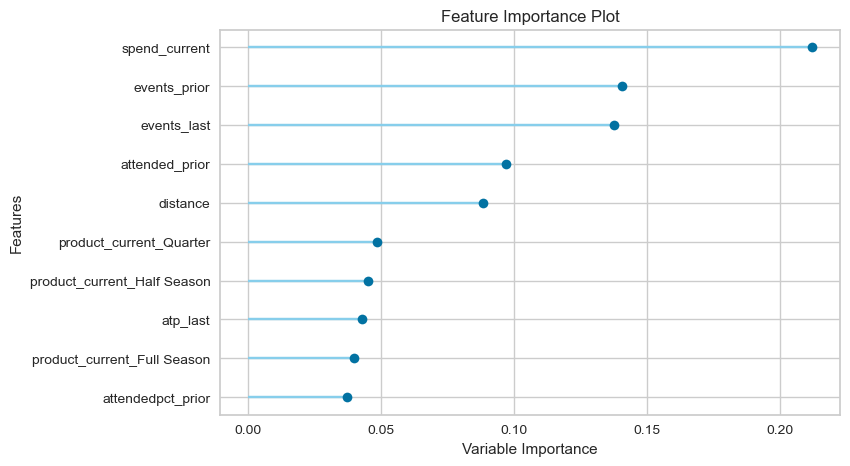

In [17]:
plot_model(final_model, plot='feature')

## Model Evaluate

### Let's load in our evaluate data and get scores using the model (it takes the leftover data from the train/test split in setup() )

In [18]:
df_scores = predict_model(final_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9958,1.0000,0.9826,0.9958,0.9958,0.9919,0.9919


## Evaluate Model (Metrics)

In [19]:
from sklearn.metrics import classification_report
def get_model_metrics(eval_data):
    
    eval_report = classification_report(eval_data["product"], eval_data["Label"], output_dict=True)
    
    results = {
        "multiclass_classification_metrics": {
            "Accuracy": {"value": eval_report["accuracy"]},
            "Precision": {"value": eval_report["macro avg"]["precision"]},
            "Recall": {"value": eval_report["macro avg"]["recall"]},
            "F1": {"value": eval_report["macro avg"]["f1-score"]}
        }
    }
    
    return results

In [20]:
metrics = get_model_metrics(df_scores)

In [21]:
print(metrics)

{'multiclass_classification_metrics': {'Accuracy': {'value': 0.9958071278825996}, 'Precision': {'value': 0.9978170372626662}, 'Recall': {'value': 0.9826152683295539}, 'F1': {'value': 0.9900475583607555}}}


| Accuracy |	AUC |	Recall |	Prec |	F1	| Kappa |	MCC |
| -- | -- | -- | -- | -- | -- | --|
|0.9777 |	0.9985|	0.9164|	0.9776|	0.9773|	0.9563|	0.9564|
|0.9965|	1.0000|	0.9839|	0.9965|	0.9965|	0.9932|	0.9933|

^ First is the standard model setup. Second row is with `distance`, `product_current`, and `product_last`

# Inference

In [ ]:
df_inference = helpers.get_product_propensity_dataset(
    cluster=CLUSTER,
    database=DATABASE,
    lkupclientid=LKUPCLIENTID,
    scoring_year=SCORING_YEAR,
    type_flag=1
)

# remove the target column from the inference df
df_inference = df_inference.drop(columns=["product"], axis=1)

df_inference.shape

In [ ]:
df_scores = predict_model(final_model, data=df_inference)

## Upsell Leads

In [13]:
df_upsell = df_scores[df_scores["product_current"].isin(product_plans)]

df_upsell_aggs = df_upsell.groupby(["Label","product_current"]).agg({
    "Label": "count",
})
df_upsell_aggs.columns = ["count"]

df_upsell_aggs

count
Label       product_current       
Full Season Full Season        214
            Half Season         31
            Mini Pack            5
            Quarter              9
Half Season Full Season          5
            Half Season         45
            Mini Pack            3
            Quarter              4
Mini Pack   Full Season          2
            Mini Pack            6
            Quarter              2
Quarter     Full Season         12
            Half Season         39
            Mini Pack           23
            Quarter            270

## Individual + None Leads

In [14]:
df_other = df_scores[df_scores["product_current"].isin(["Individual", "None"])]

### Let's examine the top 20 Full Season leads in this grouping:

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df_other[df_other["Label"]=="Full Season"].sort_values(by="Score", ascending=False).head(20)